In [44]:
# import packages
import sys

import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt

from global_land_mask import globe

import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax 
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# setting up figure parameters
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (15.0/2, 20.0/2)

# Data preparation

In [163]:
# read in data
ORAp_t = '../data/sosstsst_control_regrid_monthly_3D_195801-201412.nc'
ORAp_h = '../data/sossheig_control_regrid_monthly_3D_195801-201412.nc'
ORAp_s = '../data/sosaline_control_regrid_monthly_3D_195801-201412.nc'
ORAp_m = '../data/somxl030_control_regrid_monthly_3D_195801-201412.nc'

ORA_SST = nc.Dataset(ORAp_t).variables['sst'][:]
ORA_SSH = nc.Dataset(ORAp_h).variables['ssh'][:]
ORA_SSS = nc.Dataset(ORAp_s).variables['sss'][:]
ORA_MLD = nc.Dataset(ORAp_m).variables['mxl'][:]

monthofYear = np.arange(1, np.shape(ORA_SST)[0]+1)
 
lat = nc.Dataset(ORAp_t).variables['lat'][:] #all nc files are regridded to same latlon values
lon = nc.Dataset(ORAp_t).variables['lon'][:]

# change fill values to NaNs
ORA_SST = np.where(np.abs(ORA_SST)>10000., np.nan, ORA_SST)
ORA_SSH = np.where(np.abs(ORA_SSH)>10000., np.nan, ORA_SSH)
ORA_SSS = np.where(np.abs(ORA_SSS)>10000., np.nan, ORA_SSS)
ORA_SST = ma.masked_array(ORA_SST, np.isnan(ORA_SST))
ORA_SSH = ma.masked_array(ORA_SSH, np.isnan(ORA_SSH))
ORA_SSS = ma.masked_array(ORA_SSS, np.isnan(ORA_SSS))

In [178]:
# calculate climatology for every grid
OSST_c = np.mean(np.array(ORA_SST).reshape((int(ORA_SST.shape[0]/12), 12, len(lat), len(lon))), axis=0)   # NaNs varies with time, so instead of using np.nanmean, use np.mean
OSSH_c = np.mean(np.array(ORA_SSH).reshape((int(ORA_SSH.shape[0]/12), 12, len(lat), len(lon))), axis=0)
OSSS_c = np.mean(np.array(ORA_SSS).reshape((int(ORA_SSS.shape[0]/12), 12, len(lat), len(lon))), axis=0)
OMLD_c = np.mean(np.array(ORA_MLD).reshape((int(ORA_MLD.shape[0]/12), 12, len(lat), len(lon))), axis=0)

OSST_cf = np.tile(OSST_c, (int(ORA_SST.shape[0]/12),1,1))
OSSH_cf = np.tile(OSSH_c, (int(ORA_SSH.shape[0]/12),1,1))
OSSS_cf = np.tile(OSSS_c, (int(ORA_SSS.shape[0]/12),1,1))
OMLD_cf = np.tile(OMLD_c, (int(ORA_MLD.shape[0]/12),1,1))

OSST_cf = ma.masked_array(OSST_cf, np.isnan(OSST_cf))
OSSH_cf = ma.masked_array(OSSH_cf, np.isnan(OSSH_cf))
OSSS_cf = ma.masked_array(OSSS_cf, np.isnan(OSSS_cf))

# remove climatology (just for predictors)
OSST_a = ORA_SST - OSST_cf
OSSH_a = ORA_SSH - OSSH_cf
OSSS_a = ORA_SSS - OSSS_cf

# mask MLD by the mask of OSST_a, because NaNs of MLD also vary with time
mask = ma.getmask(OSST_a[0,:,:])
ORA_MLD = np.where(mask==True, np.nan, ORA_MLD)
ORA_MLD = ma.masked_array(ORA_MLD, np.isnan(ORA_MLD))

In [181]:
def PCAdata(data):
    # 3D to 2D
    data2D = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    
    # remove land NaNs
    result = []
    for i in np.arange(0,data.shape[0]):
        result.append(ma.compressed(data2D[i,:]).tolist())
    
    output = np.array(result)
    
    # tranpose data to [grid, time]
    outputT = np.transpose(output)
    
    # standardize data
    mean = np.mean(outputT, axis=0)
    std = np.std(outputT, axis=0)
    
    return (outputT-mean)/std

In [182]:
OSST_cf_pca = PCAdata(OSST_cf)
OSSH_cf_pca = PCAdata(OSSH_cf)
OSSS_cf_pca = PCAdata(OSSS_cf)
OSST_a_pca = PCAdata(OSST_a)
OSSH_a_pca = PCAdata(OSSH_a)
OSSS_a_pca = PCAdata(OSSS_a)
OMLD_pca   = PCAdata(ORA_MLD)

In [138]:
OSST_cf_pca.shape

(27277, 684)

# Unsupervised learning: PCA

In [183]:
# calculate covariance matrix
CSST_cf = 1./np.size(OSST_cf_pca, axis=0)*np.dot(np.transpose(OSST_cf_pca),OSST_cf_pca)
CSSH_cf = 1./np.size(OSSH_cf_pca, axis=0)*np.dot(np.transpose(OSSH_cf_pca),OSSH_cf_pca)
CSSS_cf = 1./np.size(OSSS_cf_pca, axis=0)*np.dot(np.transpose(OSSS_cf_pca),OSSS_cf_pca)
CSST_a = 1./np.size(OSST_a_pca, axis=0)*np.dot(np.transpose(OSST_a_pca),OSST_a_pca)
CSSH_a = 1./np.size(OSSH_a_pca, axis=0)*np.dot(np.transpose(OSSH_a_pca),OSSH_a_pca)
CSSS_a = 1./np.size(OSSS_a_pca, axis=0)*np.dot(np.transpose(OSSS_a_pca),OSSS_a_pca)

CMLD = 1./np.size(OMLD_pca, axis=0)*np.dot(np.transpose(OMLD_pca),OMLD_pca)

CSST_cf.shape

(684, 684)

In [184]:
# calculate eigenvalues and eigenvectors
lamSST_cf, ESST_cf = np.linalg.eig(CSST_cf)
lamSSH_cf, ESSH_cf = np.linalg.eig(CSSH_cf)
lamSSS_cf, ESSS_cf = np.linalg.eig(CSSS_cf)
lamSST_a, ESST_a = np.linalg.eig(CSST_a)
lamSSH_a, ESSH_a = np.linalg.eig(CSSH_a)
lamSSS_a, ESSS_a = np.linalg.eig(CSSS_a)

lamMLD, EMLD = np.linalg.eig(CMLD)

print(lamSST_cf.shape)
print(ESST_cf.shape)

(684,)
(684, 684)


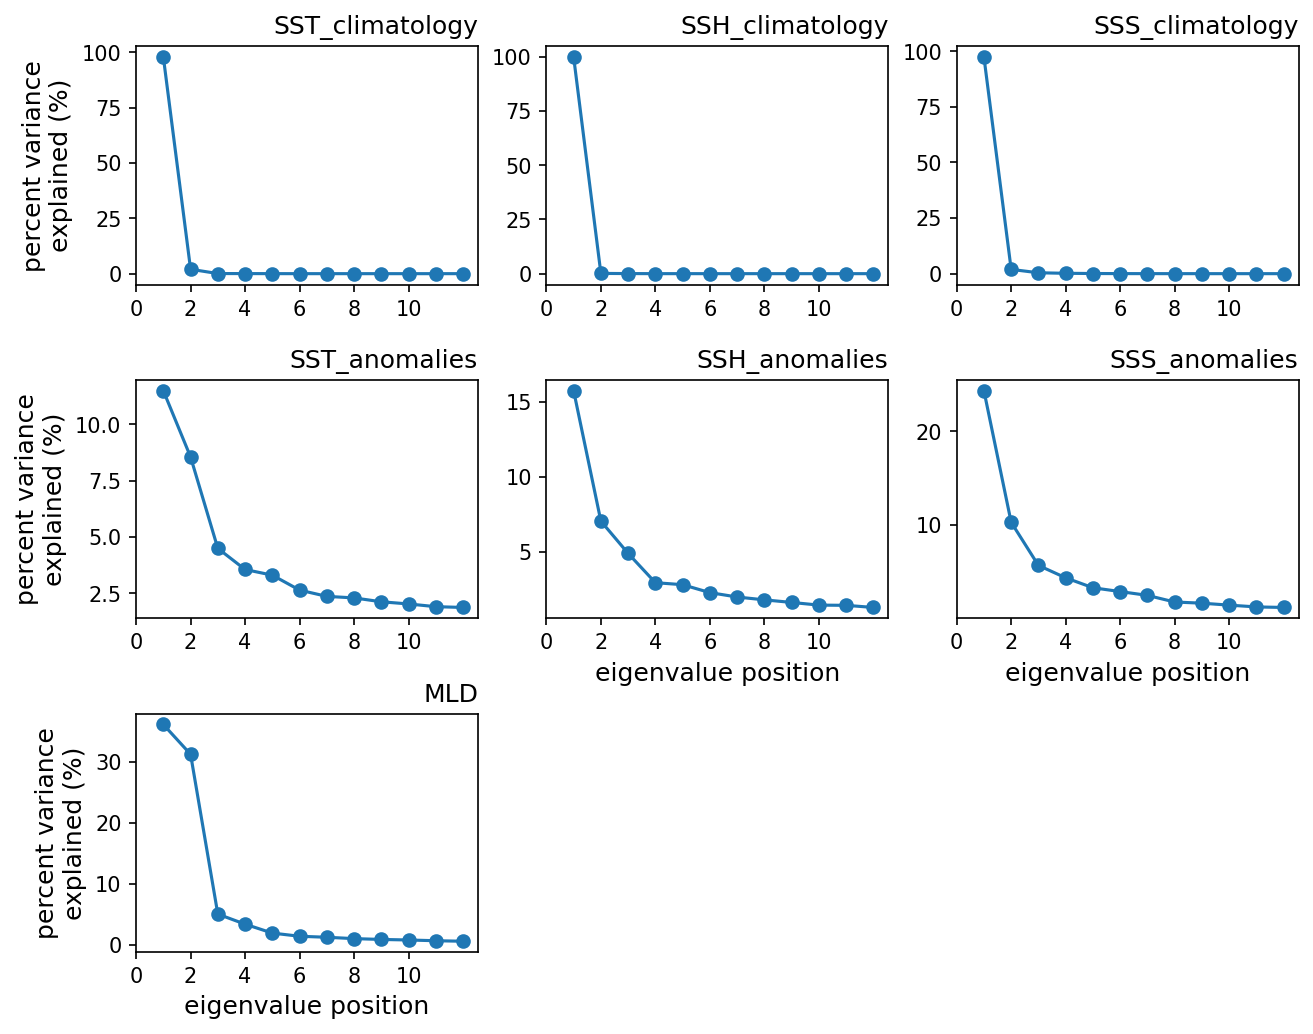

In [187]:
# convert eigenvalues to percent variance explaiend
pveSST_cf = 100.*lamSST_cf.real/np.sum(lamSST_cf.real)
pveSSH_cf = 100.*lamSSH_cf.real/np.sum(lamSSH_cf.real)
pveSSS_cf = 100.*lamSSS_cf.real/np.sum(lamSSS_cf.real)
pveSST_a = 100.*lamSST_a.real/np.sum(lamSST_a.real)
pveSSH_a = 100.*lamSSH_a.real/np.sum(lamSSH_a.real)
pveSSS_a = 100.*lamSSS_a.real/np.sum(lamSSS_a.real)

pveMLD = 100.*lamMLD.real/np.sum(lamMLD.real)

# plot explained variance
plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.subplot(3,3,1)
plt.plot(np.arange(1,13), pveSST_cf[:12], 'o-')  # only the first 12 lambda
plt.xticks(np.arange(0,12,2), np.arange(0,12,2))
plt.title('SST_climatology', loc='right')
plt.ylabel('percent variance\nexplained (%)')

plt.subplot(3,3,2)
plt.plot(np.arange(1,13), pveSSH_cf[:12], 'o-')
plt.xticks(np.arange(0,12,2), np.arange(0,12,2))
plt.title('SSH_climatology', loc='right')

plt.subplot(3,3,3)
plt.plot(np.arange(1,13), pveSSS_cf[:12], 'o-')
plt.xticks(np.arange(0,12,2), np.arange(0,12,2))
plt.title('SSS_climatology', loc='right')

plt.subplot(3,3,4)
plt.plot(np.arange(1,13), pveSST_a[:12], 'o-')
plt.xticks(np.arange(0,12,2), np.arange(0,12,2))
plt.title('SST_anomalies', loc='right')
plt.ylabel('percent variance\nexplained (%)')

plt.subplot(3,3,5)
plt.plot(np.arange(1,13), pveSSH_a[:12], 'o-')
plt.xticks(np.arange(0,12,2), np.arange(0,12,2))
plt.title('SSH_anomalies', loc='right')
plt.xlabel('eigenvalue position')

plt.subplot(3,3,6)
plt.plot(np.arange(1,13), pveSSS_a[:12], 'o-')
plt.xticks(np.arange(0,12,2), np.arange(0,12,2))
plt.title('SSS_anomalies', loc='right')
plt.xlabel('eigenvalue position')

plt.subplot(3,3,7)
plt.plot(np.arange(1,13), pveMLD[:12], 'o-')
plt.xticks(np.arange(0,12,2), np.arange(0,12,2))
plt.title('MLD', loc='right')
plt.xlabel('eigenvalue position')
plt.ylabel('percent variance\nexplained (%)')

plt.show()

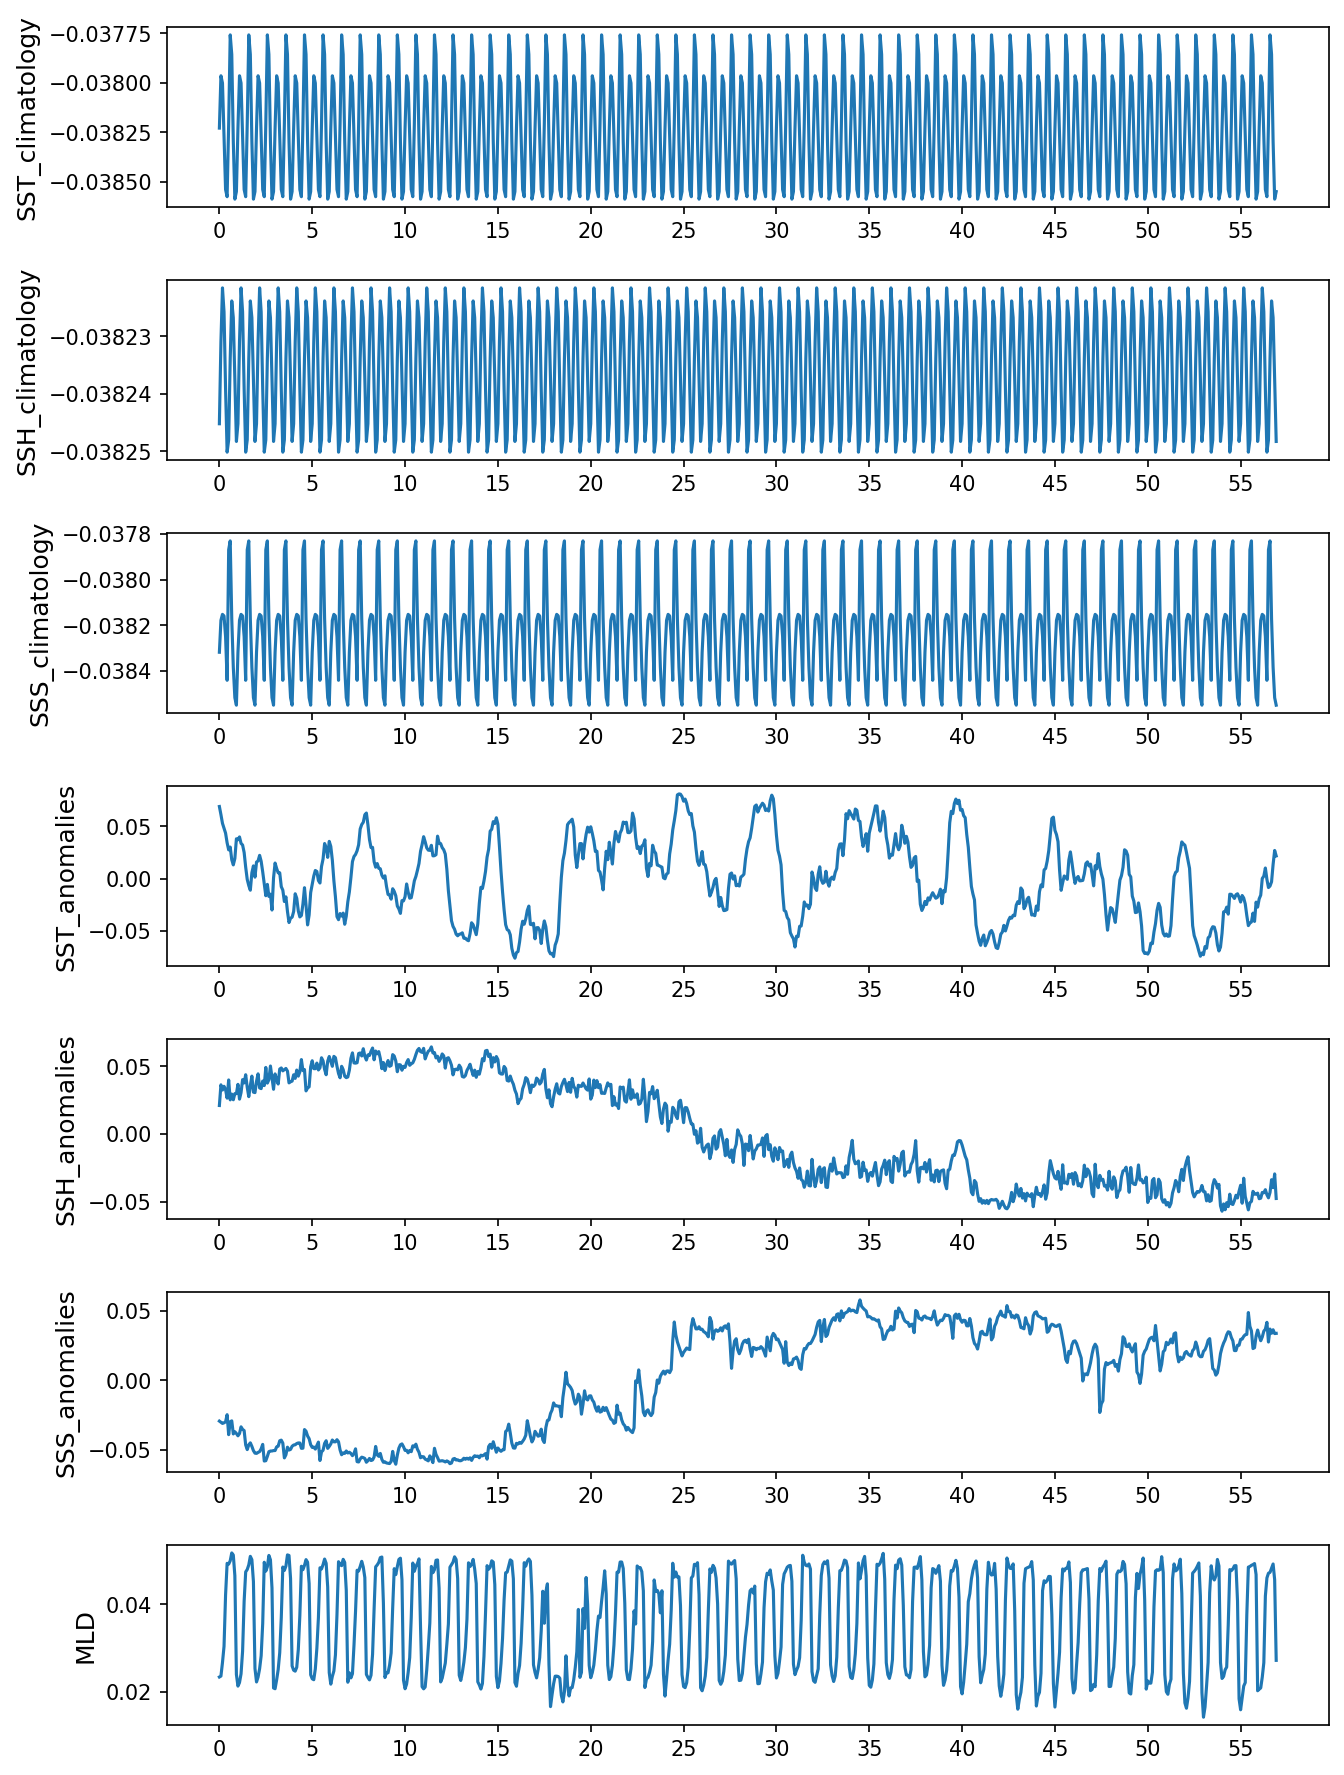

In [203]:
# check on first EOF
plt.figure(figsize=(10,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.subplot(7,1,1)
plt.plot(ESST_cf[:,0])
plt.xticks(np.arange(0,ESST_cf.shape[0],60), np.arange(0,56,5))
plt.ylabel('SST_climatology')

plt.subplot(7,1,2)
plt.plot(ESSH_cf[:,0])
plt.xticks(np.arange(0,ESSH_cf.shape[0],60), np.arange(0,56,5))
plt.ylabel('SSH_climatology')

plt.subplot(7,1,3)
plt.plot(ESSS_cf[:,0])
plt.xticks(np.arange(0,ESSS_cf.shape[0],60), np.arange(0,56,5))
plt.ylabel('SSS_climatology')

plt.subplot(7,1,4)
plt.plot(ESST_a[:,0])
plt.xticks(np.arange(0,ESST_a.shape[0],60), np.arange(0,56,5))
plt.ylabel('SST_anomalies')

plt.subplot(7,1,5)
plt.plot(ESSH_a[:,0])
plt.xticks(np.arange(0,ESSH_cf.shape[0],60), np.arange(0,56,5))
plt.ylabel('SSH_anomalies')

plt.subplot(7,1,6)
plt.plot(ESSS_a[:,0])
plt.xticks(np.arange(0,ESSS_cf.shape[0],60), np.arange(0,56,5))
plt.ylabel('SSS_anomalies')

plt.subplot(7,1,7)
plt.plot(EMLD[:,0])
plt.xticks(np.arange(0,EMLD.shape[0],60), np.arange(0,56,5))
plt.ylabel('MLD')

plt.show()

# Training ANN model on just the first EOF

In [204]:
# predictors and predictand
X = np.empty((OSST_a.shape[0], 7))
X[:,:] = np.nan

X[:,0] = ESST_cf[:,0]
X[:,1] = ESSH_cf[:,0]
X[:,2] = ESSS_cf[:,0]
X[:,3] = ESST_a[:,0]
X[:,4] = ESSH_a[:,0]
X[:,5] = ESSS_a[:,0]
X[:,6] = monthofYear

y = np.copy(ORA_MLD)

label_names = ['MLD']
feature_list = ['month of year', 'SST - climatology', 'SSH - climatology', 'SSS - climatology', 'SST - anomaly', 'SSH - anomaly', 'SSS - anomaly']